2/24/24

This Notebook uses a lot of code from calcSimSystamatics (same directory), but compares a simulation and measurement from a monopole drive

- VNA is calibrated at end of chode cable. IE chode cable is calibrated out and refrence plane at at the bicon's port
- port 1 is bicon, 2 is monopole (both simulation and measurement). This was flipped for a sigle lab book entry on 2/23/24, but is now consistant
- data and calibration are saved in this directory. There are some notes in google doc lab book on 2_24_24


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib widget

In [2]:
#pack df of measured data (from amin) from CSVs



# Directory containing the CSV files
data_dir_new = '/drBigBoy/darkRadio/comsolSimulations/run1A_simulation_10_3_23/monopoleDriveSimValidation/data_2_24_24/'

# List of file indices to ignore
bad_data_idx = []

# Columns to extract from the CSV
columns_to_extract = ['Frequency', 'S11_Magnitude', 'S11_Phase', 'S22_Magnitude', 'S22_Phase', 'S12_Magnitude', 'S12_Phase']

# Initialize an empty DataFrame to hold the data
df_meas = pd.DataFrame()

# List all files in the directory that match the pattern and are not in the bad data index
for filename in os.listdir(data_dir_new):
    if filename.startswith('sParamData_p') and filename.endswith('.csv'):
        # Extract index from the filename and check if it's not in the bad data list
        file_idx = int(filename.split('p')[-1].split('.')[0])  # Extract the number after 'p'
        if file_idx not in bad_data_idx:
            # Construct full file path
            file_path = os.path.join(data_dir_new, filename)
            # Read the CSV file
            temp_df = pd.read_csv(file_path, usecols=columns_to_extract)
            # Add the index column
            temp_df['Index'] = file_idx
            # Append to the main DataFrame
            df_meas = pd.concat([df_meas, temp_df], ignore_index=True)

#VNA has glitch at 62.00MHz. Replace it with average of two adjacent bins
# Filter rows for the frequencies 61928888 and 62071111 across all indexes
adjacent_freqs_df = df_meas[df_meas['Frequency'].isin([61928888, 62071111])]

# Calculate the average for each S parameter for these frequencies by Index
avg_s_params = adjacent_freqs_df.groupby('Index').mean().drop(columns=['Frequency'])

# Replace the S parameters for frequency 62000000 Hz with the calculated averages
for idx, row in avg_s_params.iterrows():
    df_meas.loc[(df_meas['Frequency'] == 62000000) & (df_meas['Index'] == idx), ['S11_Magnitude', 'S11_Phase', 'S12_Magnitude', 'S12_Phase', 'S22_Magnitude', 'S22_Phase']] = row.values


df_meas['S11_Magnitude_Linear'] = 10 ** (df_meas['S11_Magnitude'] / 20.0)
df_meas['S22_Magnitude_Linear'] = 10 ** (df_meas['S22_Magnitude'] / 20.0)
df_meas['S12_Magnitude_Linear'] = 10 ** (df_meas['S12_Magnitude'] / 20.0)

print("unique sorted position indicies: ",np.sort(df_meas['Index'].unique()))

# Now combined_df contains all the data from the CSV files excluding the bad indices
df_meas.head()  # Show the first few rows of the DataFrame


unique sorted position indicies:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


,Frequency,S11_Magnitude,S11_Phase,S12_Magnitude,S12_Phase,S22_Magnitude,S22_Phase,Index,S11_Magnitude_Linear,S22_Magnitude_Linear,S12_Magnitude_Linear
0,30000000,-0.618858,-111.386332,-62.954829,-98.668651,0.078723,-8.863799,8,0.931230,1.009104,0.000712
1,30071111,-0.550007,-112.021716,-76.029575,47.294815,0.036788,-8.786781,8,0.938641,1.004244,0.000158
2,30142222,-0.545370,-112.748676,-76.620454,48.545765,0.036914,-8.800341,8,0.939143,1.004259,0.000148
3,30213333,-0.540811,-113.470659,-76.205563,38.262459,0.036941,-8.806801,8,0.939636,1.004262,0.000155
4,30284444,-0.539380,-114.201313,-77.099415,52.980421,0.037063,-8.819466,8,0.939790,1.004276,0.000140


In [3]:
###############################################
#  pack DF of comsol data  ####################
###############################################

import os
from os import listdir
from os.path import isfile, join
import fnmatch
import re
directory   = './comsolData_gitignore/40_310MHz_500Q_moveAnt_9pos_3wallDrive_steelWalls_2_25_24/' #include trailing `/`

'''
Open and process comsol data files. Save to one large dataframe. 

DF columns:
positionIdx, freq, Ex_near, Ey_n, Ez_n, Enorm_n, Ex_all, Ey_a, Ez_a, Enorm_a, LPV 

Rows:
frequency

shape = (postions * frequency steps) x (11)
size = (1 +(10*4))bytes * nPostions * nFrequencies
18 postions, 1000 frequencies size = 0.73MB

Also save text file with look up table of 
postionIdx, X, Y, Z, Alpha, Beta, Gamma
'''

def convert_to_complex(s):
    return complex(s.replace('i', 'j'))


#get list of files in directory
files = [f for f in listdir(directory) if isfile(join(directory, f))]
assert files != [], f"empty list in {directory}"

#generate list of file names that match pattern strings
#assumes order of "near, all, lpv"!!!!
pattern_strs    = ['.*allE.*all.*', '.*s12*.*', '.*s22_9pos*.*'] 
fileNames       = []
for pattern_str in pattern_strs:
    pattern     = re.compile(pattern_str, re.IGNORECASE)
    fileName    = [s for s in files if pattern.match(s)]
    try: 
        assert len(fileName) == 1
    except:
        print(f"No files or multple files match ' {pattern_str}. Check directory {directory}\n")
        continue
    fileNames.append(fileName[0])
assert len(fileNames) != 0, f'no files in {directory} match'

print(f'{len(fileNames)} File names will be used to create DF:')
for file in fileNames: print(file)  

dfOut = pd.DataFrame()

#perform fuckary to fix comsol's stupid text file output. 
#modify 4th row of text (column names) to have white space delimiter and split on whitespace
for fileIdx, fileName in enumerate(fileNames):
    with open(directory + fileName, 'r') as f:
        data = f.readlines()
    data[4] = data[4].replace('%','')
    data[4] = data[4].replace(' (cm)','(cm)')
    data[4] = data[4].replace(' (MHz)','(MHz)')
    data[4] = data[4].replace('abs(emw.Ex) (V/m), Point: (', ' Ex_atPoint(') #header must start with 'E<i>' 
    data[4] = data[4].replace('abs(emw.Ey) (V/m), Point: (', ' Ey_atPoint(') #on these 3 lines.
    data[4] = data[4].replace('abs(emw.Ez) (V/m), Point: (', ' Ez_atPoint(')
    data[4] = data[4].replace('abs(emw.normE) (V/m), Point: (', ' Enorm_atPoint(')
    data[4] = data[4].replace(', ',',')
    data[4] = data[4].replace('(V)','')
    data[4] = data[4].replace('abs(emw.S12) (1)','S12')
    data[4] = data[4].replace('abs(emw.S22) (1)','S22')
    
    header = data[4].split()
    print()
    print('Working on: ', fileName)
    #print(header)
    # read the file and skip the first 5 rows, get column names from header defined above
    df = pd.read_csv(directory + fileName, delim_whitespace=True, skiprows=5, header=None)
    df.columns = header

    #overwrite position and frequency columns to make life easy
    positionCol = df[[col for col in df if col.startswith('positionIdx')]]
    #print(positionCol)
    dfOut['positionIdx'] = positionCol.astype(np.int16)
    freqCol = df[[col for col in df if col.startswith('freq')]]
    dfOut['freq(MHz)'] = freqCol.astype(np.float32)

    ############## Data extraction. Modify here to add new files ##############

    #extract field from non LPV files
    #if ('LPV' not in fileName) and ('lpv' not in fileName) and ('Lpv' not in fileName):
    if ('allE_' in fileName):
        #print(fileName)
        fieldCompStrs   = ['Ex', 'Ey', 'Ez', 'Enorm']
        if ('near' in fileName) or ('Near' in fileName):
            fieldLoc = '_near'
        else:
            fieldLoc = '_all'
        for fieldCompStr in fieldCompStrs:
            filter_col = [col for col in df if col.startswith(fieldCompStr)]
            try:
                assert filter_col != []
            except:
                print(f'no data for {fieldCompStr} in {fileName}')
            dfOut[fieldCompStr+fieldLoc] = df[filter_col].mean(axis=1).astype(np.float32)
    #else extract LPV from LPV file
    if ('LPV' in fileName) or ('lpv' in fileName) or ('Lpv' in fileName):
        filter_col = [col for col in df if col.startswith('abs(emw.Vport')]
        dfOut['LPV'] = df[filter_col].astype(np.float32)
    if ('s12' in fileName):
        filter_col = [col for col in df if col.startswith('S12')]
        dfOut['s12'] = df[filter_col].astype(np.float32)
    if ('s22' in fileName):
        filter_col = [col for col in df if col.startswith('S22')]
        dfOut['s22'] = df[filter_col].astype(np.float32)
def dBs11ToLin(dB):
    return 10**(dB/20)
#dfOut['s11'] = dfOut['s11'].transform(dBs11ToLin)
dfOut
#dfOut.to_pickle(directory+'dataDf.npy')

3 File names will be used to create DF:
allE_all_64pos.txt
s12_9pos_2_25_24.txt
s22_9pos_2_25_24.txt

Working on:  allE_all_64pos.txt

Working on:  s12_9pos_2_25_24.txt

Working on:  s22_9pos_2_25_24.txt


,positionIdx,freq(MHz),Ex_all,Ey_all,Ez_all,Enorm_all,s12,s22
0,0,40.000000,0.195592,0.409363,0.238936,0.535073,0.001578,0.999955
1,0,40.080002,0.195785,0.409533,0.239017,0.535349,0.001589,0.999954
2,0,40.160000,0.195978,0.409704,0.239099,0.535628,0.001600,0.999954
3,0,40.240002,0.196173,0.409875,0.239181,0.535907,0.001611,0.999954
4,0,40.320999,0.196371,0.410049,0.239265,0.536191,0.001623,0.999953
...,...,...,...,...,...,...,...,...
9229,8,307.612000,12.886382,12.504299,24.281326,32.748940,0.278427,0.906559
9230,8,308.227997,13.594739,13.360738,18.144409,29.234566,0.183959,0.925686
9231,8,308.843994,7.883509,8.234757,7.104292,15.009610,0.039381,0.980544
9232,8,309.462006,19.722473,20.885771,19.916111,38.469707,0.096522,0.876331


In [4]:
#load data from simpler simulation (no monopole, same everything else) 
# this is packed in ./moveAntvsModeStir/analysis_moveAntvsModeStir.ipynb
directory   = '../moveAnt_vs_modeStir/data_gitignore/40_310MHz_500Q_moveAnt_18pos_3wallDrive_steelWalls_10_8_23/' #include trailing `/`


df_comsol_onlyBicon = np.load(directory + 'dataDf.npy', allow_pickle=True)
df_comsol_onlyBicon

,positionIdx,freq(MHz),Ex_near,Ey_near,Ez_near,Enorm_near,Ex_all,Ey_all,Ez_all,Enorm_all,LPV,s11
0,0,40.000000,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999970
1,0,40.080002,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999970
2,0,40.160000,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999969
3,0,40.240002,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999969
4,0,40.320999,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999968
...,...,...,...,...,...,...,...,...,...,...,...,...
18463,17,307.612000,39.170479,12.002538,32.207817,55.924423,31.140749,13.869156,35.924980,52.330589,4.309466,0.698746
18464,17,308.227997,23.809851,19.963230,18.973083,39.374134,18.308559,15.750480,21.750729,36.250748,1.715535,0.586095
18465,17,308.843994,17.787285,13.663861,22.248446,33.732182,21.868002,7.615380,25.229118,35.925175,2.074518,0.622723
18466,17,309.462006,13.672132,13.680718,15.211812,25.982218,15.533454,7.776422,15.336432,25.544699,0.778493,0.309704


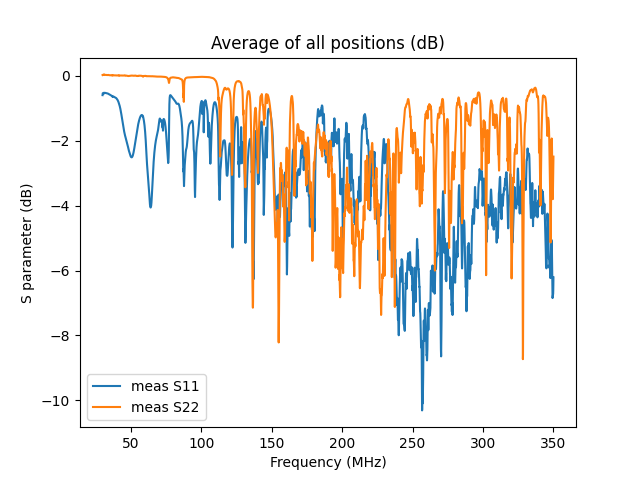

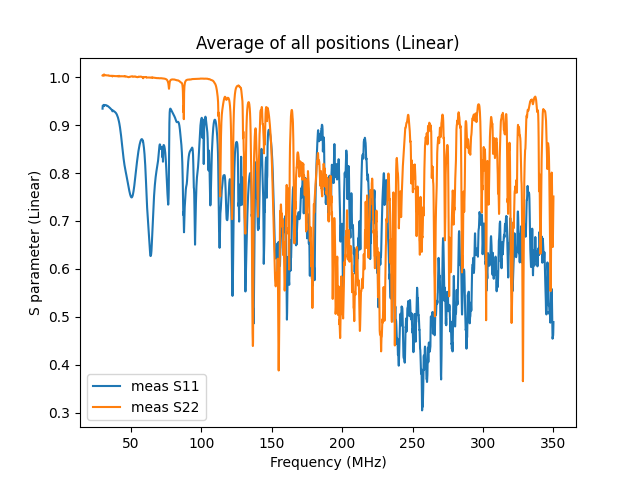

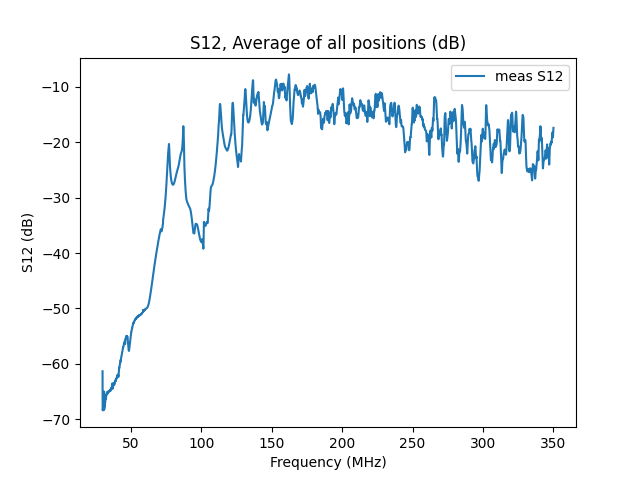

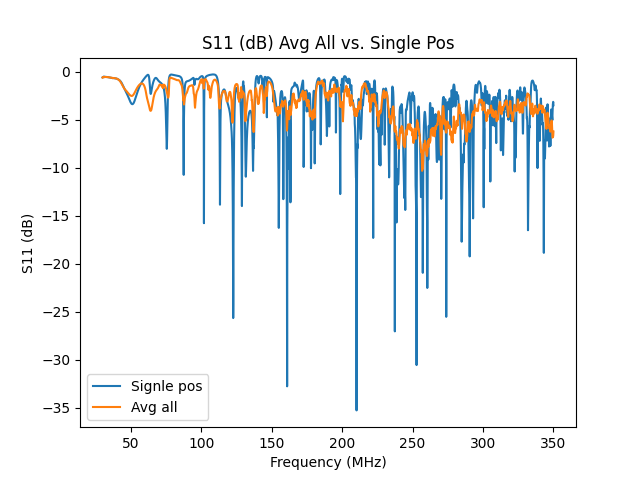

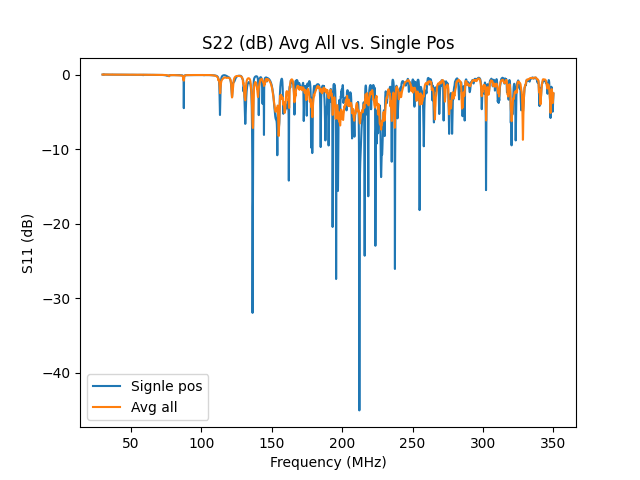

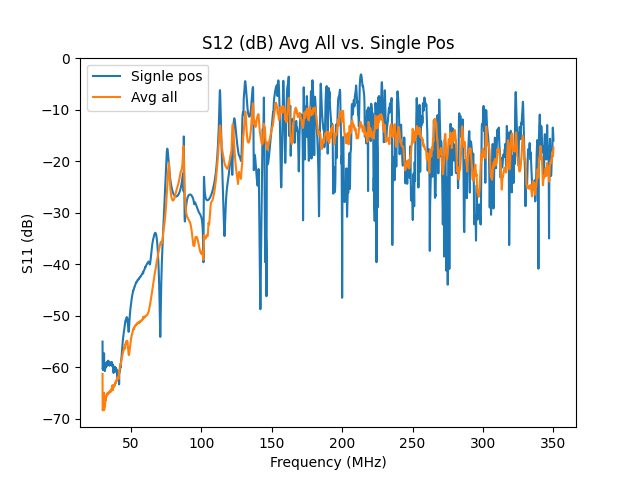

In [5]:
plt.close('all')

measured_s11_mean_all   = df_meas.groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_mean_all   = df_meas.groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_mean_all   = df_meas.groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_s11_pos0   = df_meas[df_meas['Index'] == 0].groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_pos0   = df_meas[df_meas['Index'] == 0].groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_pos0   = df_meas[df_meas['Index'] == 0].groupby('Frequency')['S12_Magnitude_Linear'].mean()


measured_freqs      = df_meas['Frequency'].unique()/1e6
#simulated_mean_all  = df_comsol.groupby('freq(MHz)')['s11'].mean()
#simulated_freqs     =df_comsol['freq(MHz)'].unique()

#filtered_df = df_comsol[df_comsol['positionIdx'].isin([0,2,4,6,8,10,12,14,16])]
#simulated_mean_9pos = filtered_df.groupby('freq(MHz)')['s11'].mean()

# Interpolate the simulated average onto the measured frequencies
#measured_interpolated_all = np.interp(simulated_freqs, measured_freqs, measured_mean_all, )

plt.figure()
plt.title("Average of all positions (dB)")
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = 'meas S11')
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = 'meas S22')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S parameter (dB)')
plt.legend()

plt.figure()
plt.title("Average of all positions (Linear)")
plt.plot(measured_freqs, measured_s11_mean_all, label = 'meas S11')
plt.plot(measured_freqs, measured_s22_mean_all, label = 'meas S22')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S parameter (Linear)')
plt.legend()

plt.figure()
plt.title("S12, Average of all positions (dB)")
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'meas S12')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S12 (dB)')
plt.legend()

plt.figure()
plt.title("S11 (dB) Avg All vs. Single Pos")
plt.plot(measured_freqs, 20*np.log10(measured_s11_pos0), label = 'Signle pos')
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = 'Avg all')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()

plt.figure()
plt.title("S22 (dB) Avg All vs. Single Pos")
plt.plot(measured_freqs, 20*np.log10(measured_s22_pos0), label = 'Signle pos')
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = 'Avg all')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()

plt.figure()
plt.title("S12 (dB) Avg All vs. Single Pos")
plt.plot(measured_freqs, 20*np.log10(measured_s12_pos0), label = 'Signle pos')
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'Avg all')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()

In [6]:
###bootstrap measured data

n_pos_avg = 18 #num antenna positions
s11_samples = []
    
plt.close('all')
#plt.figure()

for i in range(1000):
    # Randomly select 9 positions from measured and simulated datasets
    measured_positions = np.random.choice(df_meas['Index'].unique(), n_pos_avg, replace=True)
    #simulated_positions = np.random.choice(df_comsol['positionIdx'].unique(), n_pos_avg, replace=True)

    # Get all frequency points for the selected measured positions
    measured_sample = df_meas[df_meas['Index'].isin(measured_positions)]
    # Group by frequency and calculate mean S11_Magnitude for the measured data
    measured_mean = measured_sample.groupby('Frequency')['S12_Magnitude_Linear'].mean()




    s11_samples.append(measured_mean)

# Convert list of arrays into a 2D numpy array
s11_samples_array = 20*np.log10(np.vstack(s11_samples))

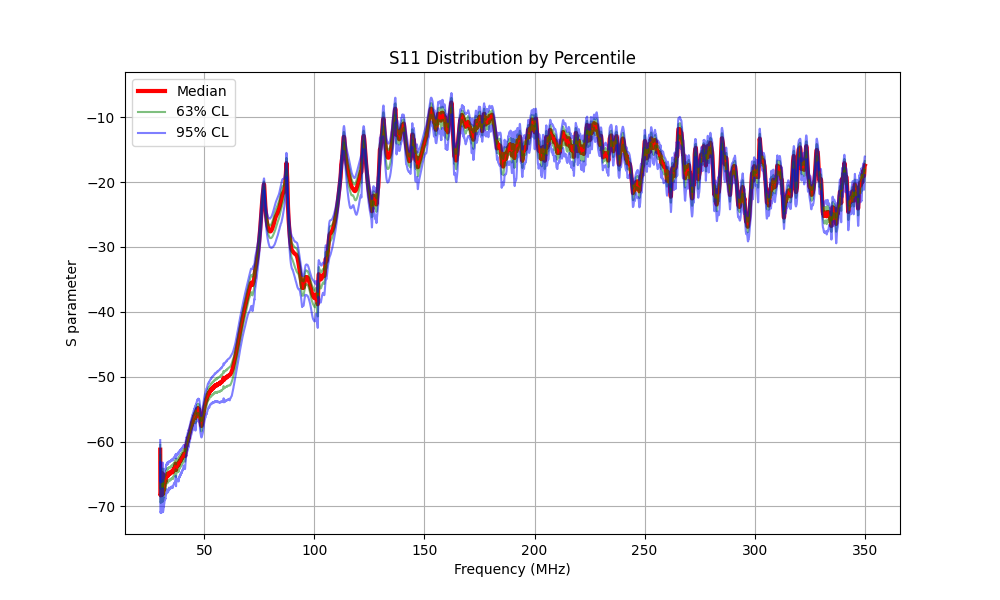

In [7]:
##### only plot median and 95% #####

# Define the list of percentiles to calculate


# Calculate median
median_s11 = np.percentile(s11_samples_array, 50 , axis=0)

# 63% s11
upper_63_s11 = np.percentile(s11_samples_array, (100-63)/2 , axis=0)
lower_63_s11 = np.percentile(s11_samples_array, 100-(100-63)/2 , axis=0)

# 95% s11
upper_95_s11 = np.percentile(s11_samples_array, (100-95)/2 , axis=0)
lower_95_s11 = np.percentile(s11_samples_array, 100-(100-95)/2 , axis=0)


plt.figure(figsize=(10, 6))

plt.xlabel('Frequency (MHz)')
plt.ylabel('S parameter')
plt.title('S11 Distribution by Percentile')
plt.plot(measured_freqs, median_s11, 'r', linewidth = 3, label = 'Median')
plt.plot(measured_freqs, upper_63_s11, 'g', label = '63% CL', alpha = .5)
plt.plot(measured_freqs, lower_63_s11, 'g', alpha = .5)
plt.plot(measured_freqs, upper_95_s11,'b', label = '95% CL', alpha = .5)
plt.plot(measured_freqs, lower_95_s11,'b', alpha = .5)
plt.legend()
plt.grid(True)
plt.show()



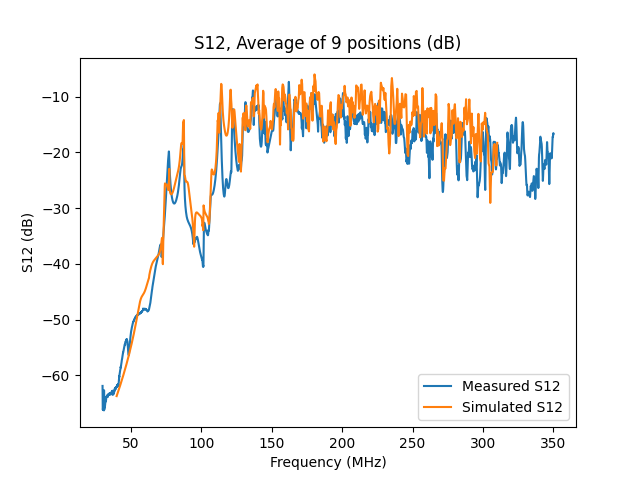

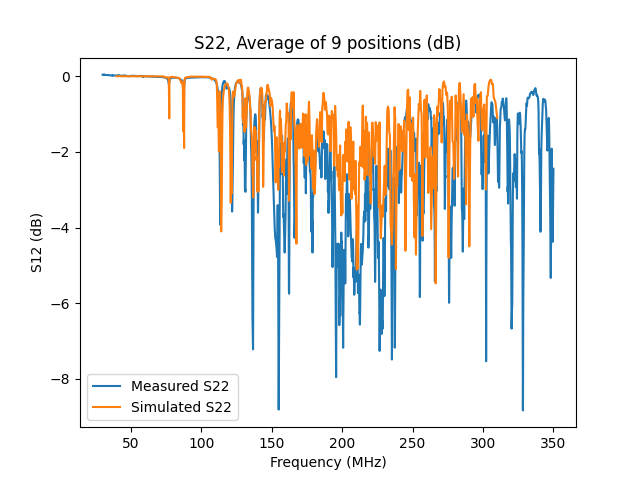

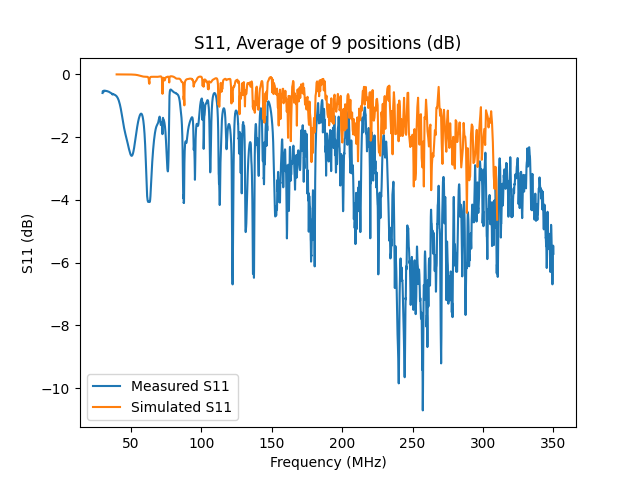

In [8]:
#compare measurement and simulation

plt.close('all')

filtered_df = df_meas[df_meas['Index'].between(0, 8)]
measured_s11_mean_9   = filtered_df.groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_mean_9   = filtered_df.groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_mean_9   = filtered_df.groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_freqs      = df_meas['Frequency'].unique()/1e6


sim_s12_allPos  = dfOut.groupby('freq(MHz)')['s12'].mean()
sim_s22_allPos  = dfOut.groupby('freq(MHz)')['s22'].mean()
sim_s11_allPos  = df_comsol_onlyBicon.groupby('freq(MHz)')['s11'].mean()
sim_freqs       = dfOut['freq(MHz)'].unique()

plt.figure()
plt.title("S12, Average of 9 positions (dB)")
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_9), label = 'Measured S12')
plt.plot(sim_freqs, 20*np.log10(sim_s12_allPos), label = 'Simulated S12')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S12 (dB)')
plt.legend()

plt.figure()
plt.title("S22, Average of 9 positions (dB)")
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_9), label = 'Measured S22')
plt.plot(sim_freqs, 20*np.log10(sim_s22_allPos), label = 'Simulated S22')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S12 (dB)')
plt.legend()

plt.figure()
plt.title("S11, Average of 9 positions (dB)")
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_9), label = 'Measured S11')
plt.plot(sim_freqs, 20*np.log10(sim_s11_allPos), label = 'Simulated S11')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()

140
3825


Text(0, 0.5, 'simulated s11')

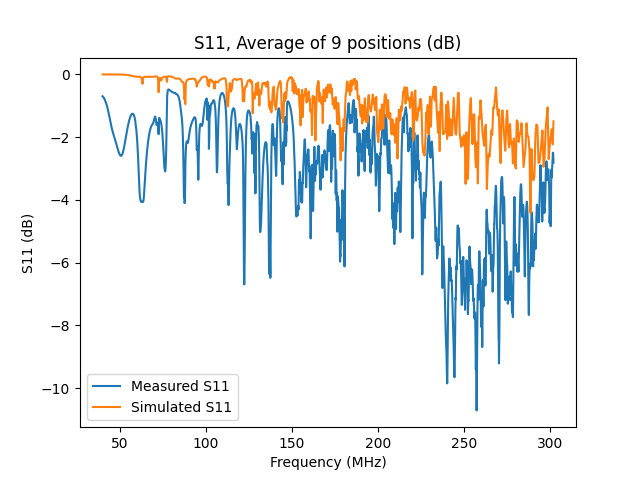

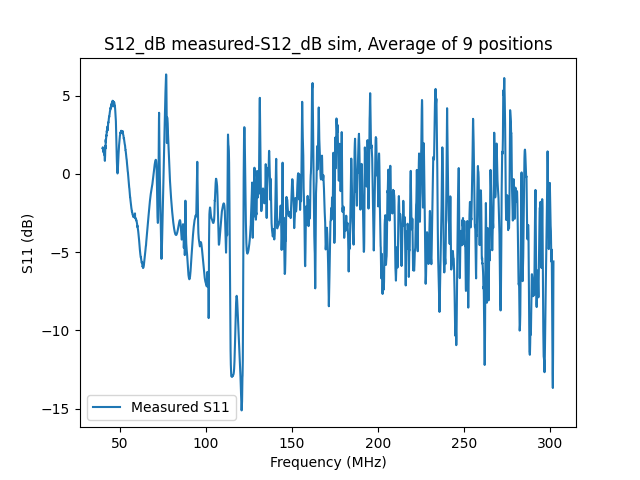

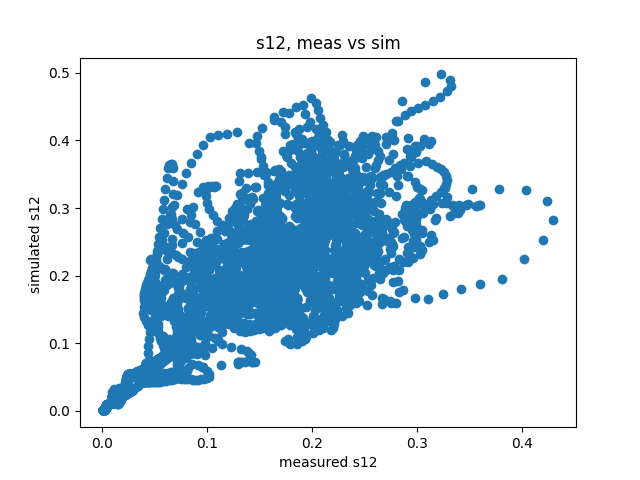

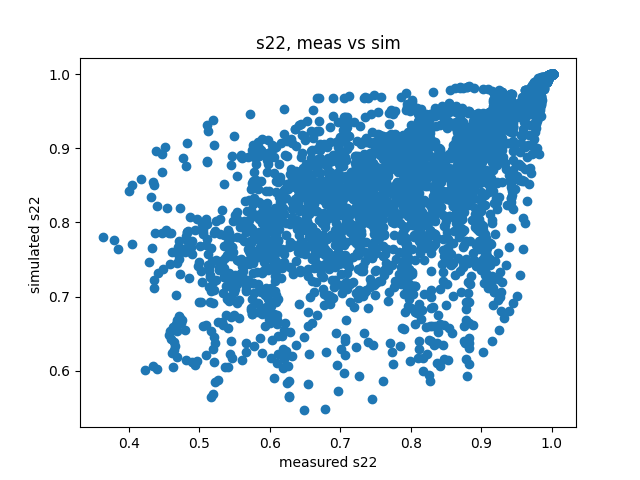

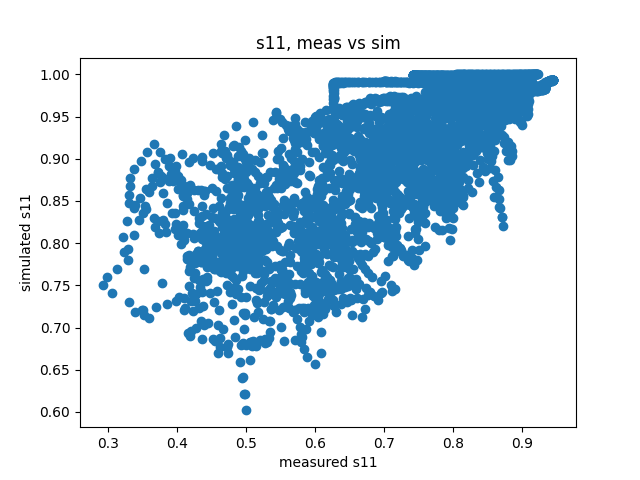

In [9]:
plt.close('all')

startIdx = int(len(measured_freqs) * (40-30)/(350-30))
stopIdx = int(len(measured_freqs) * .85)
print(startIdx)
print(stopIdx)

sim_s12_interp = np.interp(measured_freqs, sim_freqs, sim_s12_allPos)
sim_s22_interp = np.interp(measured_freqs, sim_freqs, sim_s22_allPos)
sim_s11_interp = np.interp(measured_freqs, sim_freqs, sim_s11_allPos)

plt.figure()
plt.title("S11, Average of 9 positions (dB)")
plt.plot(measured_freqs[startIdx:stopIdx], 20*np.log10(measured_s11_mean_9)[startIdx:stopIdx], label = 'Measured S11')
plt.plot(measured_freqs[startIdx:stopIdx], 20*np.log10(sim_s11_interp)[startIdx:stopIdx], label = 'Simulated S11')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()


plt.figure()
plt.title("S12_dB measured-S12_dB sim, Average of 9 positions")
plt.plot(measured_freqs[startIdx:stopIdx], (20*np.log10(measured_s12_mean_9)-20*np.log10(sim_s12_interp))[startIdx:stopIdx], label = 'Measured S11')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()



plt.figure()
plt.title('s12, meas vs sim')
plt.scatter(measured_s12_mean_9[startIdx:stopIdx], sim_s12_interp[startIdx:stopIdx])
plt.xlabel('measured s12')
plt.ylabel('simulated s12 ')

plt.figure()
plt.title('s22, meas vs sim')
plt.scatter(measured_s22_mean_9[startIdx:stopIdx], sim_s22_interp[startIdx:stopIdx])
plt.xlabel('measured s22')
plt.ylabel('simulated s22 ')

plt.figure()
plt.title('s11, meas vs sim')
plt.scatter(measured_s11_mean_9[startIdx:stopIdx], sim_s11_interp[startIdx:stopIdx])
plt.xlabel('measured s11')
plt.ylabel('simulated s11')

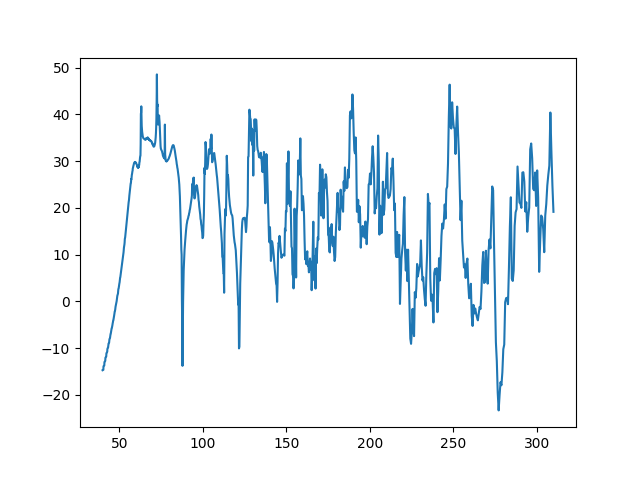

In [13]:
avgLPV = df_comsol_onlyBicon.groupby('freq(MHz)')['LPV'].mean()

P_r = avgLPV**2/50 #watts

avgQ_Ae = P_r / (np.sqrt(1)**2 / 377)

plt.figure()
plt.plot(sim_freqs, 10*np.log(avgQ_Ae))